# Statistical test for the distances between samples from case and control groups

In this notebook, we will obtain a pseudobulk patient representation, and perform a statistical test of distances between samples similar to [Petukhov et al.](https://www.biorxiv.org/content/10.1101/2022.03.15.484475v1.full.pdf)

## Install patpy

In [ ]:
!pip install git+https://github.com/lueckenlab/patpy.git@main

## Import packages

In [2]:
import scanpy as sc
import patpy

In [3]:
patpy.__version__

'0.8.1'

## Read the data

I will use [COMBAT dataset](https://zenodo.org/record/6120249/files/COMBAT-CITESeq-DATA.h5ad). You can set your own path. This is a dataset of PBMC (peripheral blood mococnuclear cells) from roughly 140 patients. There are different severity stages of COVID-19, healthy controls as well as some Flu and Sepsis patients. Can we detect differences between controls and patients? Let's see!

In [4]:
ADATA_PATH = "/Users/vladimir.shitov/Documents/programming/pat_rep_benchmark/data/combat/combat_processed.h5ad"

In [5]:
adata = sc.read_h5ad(ADATA_PATH)
adata

AnnData object with n_obs × n_vars = 783677 × 3000
    obs: 'Annotation_cluster_id', 'Annotation_cluster_name', 'Annotation_minor_subset', 'Annotation_major_subset', 'Annotation_cell_type', 'GEX_region', 'QC_ngenes', 'QC_total_UMI', 'QC_pct_mitochondrial', 'QC_scrub_doublet_scores', 'TCR_chain_composition', 'TCR_clone_ID', 'TCR_clone_count', 'TCR_clone_proportion', 'TCR_contains_unproductive', 'TCR_doublet', 'TCR_chain_TRA', 'TCR_v_gene_TRA', 'TCR_d_gene_TRA', 'TCR_j_gene_TRA', 'TCR_c_gene_TRA', 'TCR_productive_TRA', 'TCR_cdr3_TRA', 'TCR_umis_TRA', 'TCR_chain_TRA2', 'TCR_v_gene_TRA2', 'TCR_d_gene_TRA2', 'TCR_j_gene_TRA2', 'TCR_c_gene_TRA2', 'TCR_productive_TRA2', 'TCR_cdr3_TRA2', 'TCR_umis_TRA2', 'TCR_chain_TRB', 'TCR_v_gene_TRB', 'TCR_d_gene_TRB', 'TCR_j_gene_TRB', 'TCR_c_gene_TRB', 'TCR_productive_TRB', 'TCR_chain_TRB2', 'TCR_v_gene_TRB2', 'TCR_d_gene_TRB2', 'TCR_j_gene_TRB2', 'TCR_c_gene_TRB2', 'TCR_productive_TRB2', 'TCR_cdr3_TRB2', 'TCR_umis_TRB2', 'BCR_umis_HC', 'BCR_contig_qc_HC

## Set the parameters

In [6]:
layer_to_use = "X_pca"  # Representations of cells to use for sample representation. Must be in .obsm or layers
sample_id_col = "scRNASeq_sample_ID"  # Where sample or patient identificators are stored in .obs
cell_type_key = "Annotation_major_subset"  # Used for filtering of cells, but not necessary for most methods including pseudobulk
condition_col = "Outcome"  # A column in .obs that stores conditions of the samples
control_level = 6  # Value of condition_col to use as control. All others will be considered the case

## Quality control of samples

In [7]:
adata = patpy.pp.filter_small_samples(adata, sample_key=sample_id_col, sample_size_threshold=100)

0 samples removed: 


## Initialize the representation object

In [8]:
pseudobulk = patpy.tl.Pseudobulk(sample_key=sample_id_col, cell_group_key=cell_type_key, layer=layer_to_use)
pseudobulk.prepare_anndata(adata)

## Calculate a matrix of distances between samples

In [9]:
distances = pseudobulk.calculate_distance_matrix()
distances

/Users/vladimir.shitov/Documents/programming/patient_representation/src/patpy/tl/sample_representation.py:453: UserWarning: Using data from key X_pca of adata.obsm
  warnings.warn(f"Using data from key {self.layer} of adata.obsm", stacklevel=1)


array([[0.        , 4.64685369, 8.5990148 , ..., 4.5335298 , 5.75458898,
        7.98608545],
       [4.64685369, 0.        , 6.21533269, ..., 6.09671616, 5.47561426,
        5.28739787],
       [8.5990148 , 6.21533269, 0.        , ..., 9.66443214, 7.75928943,
        4.24893086],
       ...,
       [4.5335298 , 6.09671616, 9.66443214, ..., 0.        , 6.25521014,
        9.3778456 ],
       [5.75458898, 5.47561426, 7.75928943, ..., 6.25521014, 0.        ,
        5.92739653],
       [7.98608545, 5.28739787, 4.24893086, ..., 9.3778456 , 5.92739653,
        0.        ]])

## Run statistical test for the distances

In [10]:
total_test_result = pseudobulk.evaluate_representation(
    target=condition_col,
    method="distances",
    control_level=control_level,
    normalization_type="total",
    compare_by_difference=True,
)
total_test_result

{'score': 1.4071983216304598,
 'p_value': 0.0,
 'metric': 'distances',
 'control_level': 6,
 'normalization_type': 'total',
 'compare_by_difference': True,
 'n_unique': 6,
 'n_observations': 113,
 'method': 'distances'}

In [11]:
shift_test_result = pseudobulk.evaluate_representation(
    target=condition_col,
    method="distances",
    control_level=control_level,
    normalization_type="shift",
    compare_by_difference=True,
)
shift_test_result

{'score': 0.7520475783097537,
 'p_value': 0.0,
 'metric': 'distances',
 'control_level': 6,
 'normalization_type': 'shift',
 'compare_by_difference': True,
 'n_unique': 6,
 'n_observations': 113,
 'method': 'distances'}

In [12]:
var_test_result = pseudobulk.evaluate_representation(
    target=condition_col,
    method="distances",
    control_level=control_level,
    normalization_type="var",
    compare_by_difference=True,
)
var_test_result

{'score': 1.368932888187764,
 'p_value': 0.0,
 'metric': 'distances',
 'control_level': 6,
 'normalization_type': 'var',
 'compare_by_difference': True,
 'n_unique': 6,
 'n_observations': 113,
 'method': 'distances'}

### The interpretation of the results format
- **score**: difference (or ratio if `compare_by_difference==False`) between the distances in comparison groups with correction for random
- **p_value**: simulated p-value of the score
- **n_unique**: number of unique values in `condition_col`. Doesn't really matter in this case, because they transformed to "case" and "control"
- **n_observations**: number of samples. Can be less than expected if for some samples value in `condition_col` is missing

For the interpretation of different normalization types, please refer to the page 17 and figure 4 of [Petukhov et al.](https://www.biorxiv.org/content/10.1101/2022.03.15.484475v1.full.pdf)

As we can see here, all 3 appoaches detect significant differences between cases and controls. That is, distances between cases and controls are significantly higher than within these groups. Additionally, variance within patients with diseases is significantly higher than between controls.

## Plot embedding of the data for a sanity check

/Users/vladimir.shitov/miniconda3/envs/sample_representation/lib/python3.11/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm
/Users/vladimir.shitov/miniconda3/envs/sample_representation/lib/python3.11/site-packages/umap/umap_.py:1858: UserWarning: using precomputed metric; inverse_transform will be unavailable
  warn("using precomputed metric; inverse_transform will be unavailable")
/Users/vladimir.shitov/miniconda3/envs/sample_representation/lib/python3.11/site-packages/umap/umap_.py:1945: UserWarning: n_jobs value 1 overridden to 1 by setting random_state. Use no seed for parallelism.
  warn(f"n_jobs value {self.n_jobs} overridden to 1 by setting random_state. Use no seed for parallelism.")


<Axes: xlabel='UMAP_0', ylabel='UMAP_1'>

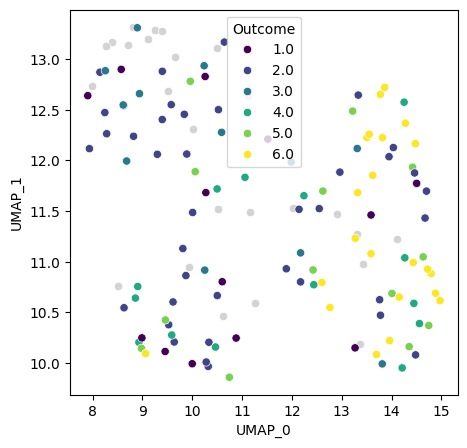

In [13]:
pseudobulk.plot_embedding(metadata_cols=[condition_col])